In [51]:
import time
import random
import matplotlib.pyplot as plt
import numpy as np

from simpleai.search import SearchProblem, breadth_first, depth_first, limited_depth_first, astar, iterative_limited_depth_first, greedy
import jps

In [52]:
from collections import deque

class MapProblem(SearchProblem):
    def __init__(self, map, initial=None, lake_goals=None, rock_goals=None, returning_allowed=False):
        self.returning_allowed = returning_allowed
        self.map = map

        while initial == None:
            y, x = random.randint(0, len(map) - 1), random.randint(0, len(map[0]) - 1)
            if map[y, x] != 'O':
                initial = (y, x)

        self.initial = (initial,  frozenset([initial]))
        
        self.lake_goals = lake_goals
        self.rock_goals = rock_goals

        if not (lake_goals and rock_goals):
            self.lake_goals = []
            self.rock_goals = []
            for y in range(len(map)):
                for x in range(len(map[y])):
                    if map[y][x] == 'O':
                        self.lake_goals.append((y, x))
                    elif map[y][x] == 'K':
                        self.rock_goals.append((y, x))

        super(MapProblem, self).__init__(initial_state=self.initial)

    def get_neighbors(self, position):
        x, y = position
        neighbors = []
        if x > 0:
            neighbors.append((x - 1, y))
        if x < len(self.map) - 1:
            neighbors.append((x + 1, y))
        if y > 0:
            neighbors.append((x, y - 1))
        if y < len(self.map[0]) - 1:
            neighbors.append((x, y + 1))
        return neighbors
    
    def get_position(self, position):
        if position in self.lake_goals:
            return 'O'
        elif position in self.rock_goals:
            return 'K'
        else:
            return 'P'


    
    def actions(self, state):
        """ Повертає можливі дії для переміщення: вліво, вправо, вверх, вниз. """
        actions = []
        (x, y), states = state

        if x > 0 and (x - 1, y) not in states:
            actions.append('UP')  # Вверх
        if x < len(self.map) - 1 and (x + 1, y) not in states:  # Вниз
            actions.append('DOWN')
        if y > 0 and (x, y - 1) not in states:  # Вліво
            actions.append('LEFT')
        if y < len(self.map[0]) - 1 and (x, y + 1) not in states:  # Вправо
            actions.append('RIGHT')

        return actions
    
    def result(self, state, action):
        """ Повертає новий стан після виконання дії. """
        (x, y), states = state
        new_position = (x, y)
        if action == 'UP':
            new_position = (x - 1, y)
        elif action == 'DOWN':
            new_position = (x + 1, y)
        elif action == 'LEFT':
            new_position = (x, y - 1)
        elif action == 'RIGHT':
            new_position = (x, y + 1)

        if not self.returning_allowed:
            states = states | {new_position}
        else:
            states = frozenset()

        return new_position, states
    
    def is_goal(self, state):
        """ Ціль досягнута, якщо знаходимось біля озера. """
        (x, y), _ = state
        return (x, y) in self.lake_goals

    def bidirectional_search(self):
        forward_frontier = deque([(self.initial[0], 'forward')])
        backward_frontier = deque([(self.lake_goals[0], 'backward')])
        explored = set()

        while forward_frontier and backward_frontier:
            # Вибираємо стан з однієї з черг, чергуючи їх для балансу
            if len(forward_frontier) <= len(backward_frontier):
                state, direction = forward_frontier.popleft()
            else:
                state, direction = backward_frontier.popleft()

            explored.add(state)

            if state in backward_frontier or state in forward_frontier:
                # Знайдено шлях
                return self.reconstruct_path(state, forward_frontier, backward_frontier)

            for neighbor in self.get_neighbors(state):
                if neighbor not in explored:
                    if direction == 'forward':
                        forward_frontier.append((neighbor, 'forward'))
                    else:
                        backward_frontier.append((neighbor, 'backward'))
                    explored.add(neighbor)

        return None  # Шлях не знайдено
    
    def reconstruct_path(self, meeting_state, forward_frontier, backward_frontier):
        forward_path = []
        current_state = meeting_state
        while current_state != self.initial:
            forward_path.append(current_state)
            current_state, _ = forward_frontier[current_state]
        forward_path.reverse()

        backward_path = []
        current_state = meeting_state
        while current_state != self.goal:
            backward_path.append(current_state)
            current_state, _ = backward_frontier[current_state]

        return forward_path + backward_path

    # def heuristic(self, state):
    #     (x, y), _ = state
    #     f = min(abs(x - lake[0]) + abs(y - lake[1]) for lake in self.lake_goals)
    #     return f - 0.5 if self.get_position((x, y)) == 'K' else f
    
    def heuristic(self, state):
        (x, y), _ = state
        f = min(abs(x - lake[0]) + abs(y - lake[1]) for lake in self.lake_goals)
        return float(f - 0.5) if self.get_position((x, y)) == 'K' else float(f)


def ida_star(problem):
    def dfs(state, g, threshold, action=None):
        f = g + problem.heuristic(state)
        if f > threshold:
            return f, None
        if problem.is_goal(state):
            return f, [(action, state)]
        min_cost = float('inf')
        for next_action in problem.actions(state):
            next_state = problem.result(state, next_action)
            cost, path = dfs(next_state, g + problem.cost(state, next_action, next_state), threshold, next_action)
            if path is not None:
                return cost, [(action, state)] + path
            min_cost = min(min_cost, cost)
        return min_cost, None

    threshold = problem.heuristic(problem.initial_state)
    while True:
        cost, path = dfs(problem.initial_state, 0, threshold)
        if path is not None:
            return path
        if cost == float('inf'):
            return None
        threshold = cost



In [53]:
def rockfield_chance(distance, max_distance, base_chance=0.9, decay_rate=2):
    normalized_distance = distance / max_distance
    if distance == 1:
        return base_chance
    elif distance <= 3:
        return 1 / (1 + np.exp(decay_rate * (normalized_distance-0.3)))
    else:
        return 0.03
    
def manhattan_dist(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

def generate_map(length, width, num_lakes):
    map = np.full((length, width), 'P', dtype=str)

    lake_goals = set()
    rock_goals = []

    while len(lake_goals) < num_lakes:
        y, x = random.randint(0, length - 1), random.randint(0, width - 1)
        lake_goals.add((y, x))
        map[y, x] = 'O'

    for y in range(length):
        for x in range(width):
            if (y, x) in lake_goals:
                continue
            nearest = min(lake_goals, key=lambda lake: manhattan_dist((y, x), lake))
            dist = manhattan_dist((y, x), nearest)
            chance = rockfield_chance(dist, 6, base_chance=0.9, decay_rate=12)

            if random.random() < chance:
                map[y][x] = 'K'
                rock_goals.append((y, x))
                
    return map, list(lake_goals), rock_goals


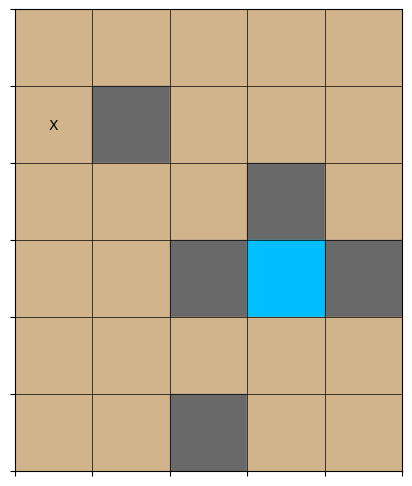

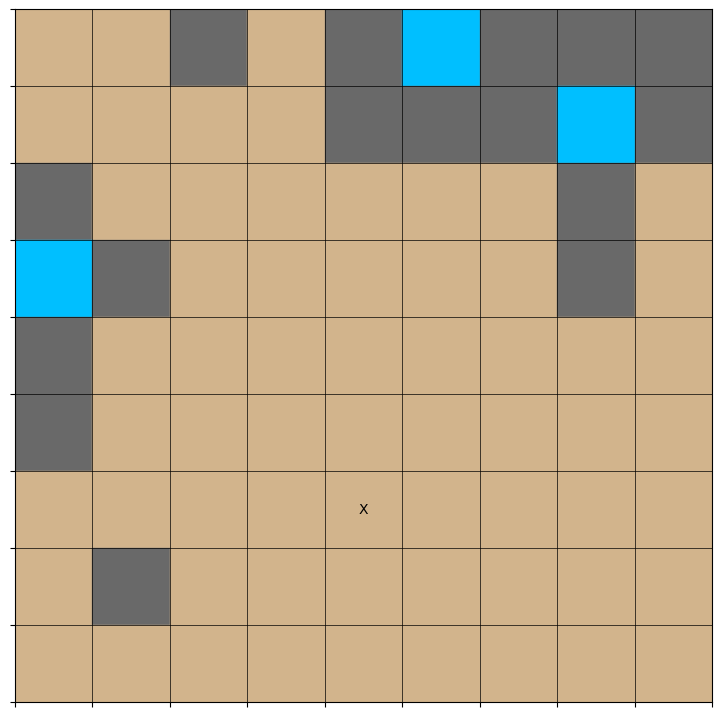

In [54]:
# Карта пустелі, де "P" - піщана клітинка, "K" - кам'яниста, "O" - озеро

desert_map = [
    ['P', 'P', 'P', 'P', 'P'],
    ['P', 'K', 'P', 'P', 'P'],
    ['P', 'P', 'P', 'K', 'P'],
    ['P', 'P', 'K', 'O', 'K'],
    ['P', 'P', 'P', 'P', 'P'],
    ['P', 'P', 'K', 'P', 'P'],
]
initial_state = (1, 0)

# Створюємо пошукову проблему
problem = MapProblem(initial=initial_state, map=desert_map, returning_allowed=False)

# Генерує ще одну мапу і створюєм пошукову проблему
generated_map, lake_goals, rock_goals = generate_map(length=9, width=9, num_lakes=3)
generated_problem = MapProblem(map=generated_map, lake_goals=lake_goals, rock_goals=rock_goals, returning_allowed=False)

# Візуалізація мапи пустелі
def visualize_map(map, initial_state=None, path=None, title=None):
    length = len(map)
    width = len(map[0])
    fig, ax = plt.subplots(figsize=(width, length))

    color_map = {
        'P': 'tan',
        'K': 'dimgray',
        'O': 'deepskyblue'
    }

    for y in range(length):
        for x in range(width):
            cell_type = map[y][x]
            color = color_map[cell_type]
            ax.add_patch(plt.Rectangle((x, length-y-1), 1, 1, color=color))
    if initial_state:
        ax.text(initial_state[1] + 0.5, length - initial_state[0] - 0.5, 'X', ha='center', va='center')
    if path:
        for x, y in path:
            ax.add_patch(plt.Rectangle((y, length - (x + 1)), 1, 1, color='yellow', alpha=0.4))

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
    ax.set_xlim(0, width)
    ax.set_ylim(0, length)

    if title:
        plt.title(title)
    plt.show()

visualize_map(map=desert_map, initial_state=initial_state)
visualize_map(map=generated_map, initial_state=generated_problem.initial[0])

Breadth-first Search: шлях знайдено
Час: 0.0005730000000028213
[None, 'DOWN', 'DOWN', 'RIGHT', 'RIGHT', 'RIGHT']


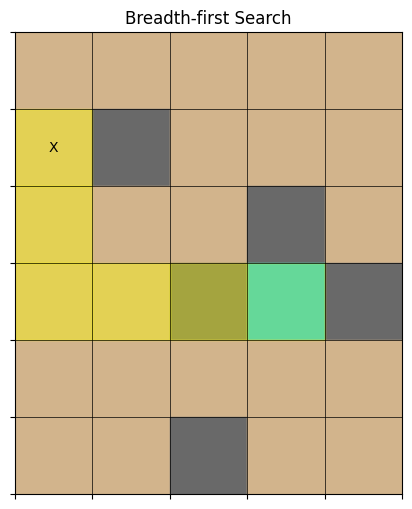

Depth-first search: шлях знайдено
Час: 0.00013899999999722468
[None, 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'RIGHT']


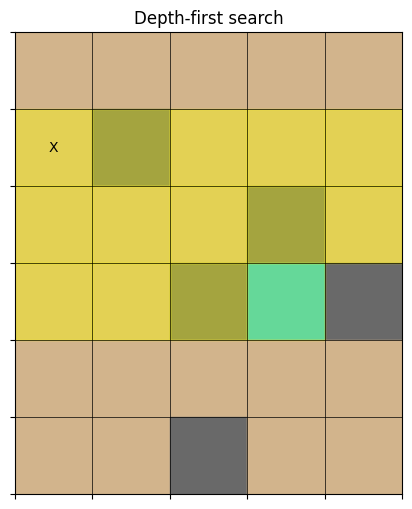

Depth-Limited Search: шлях знайдено
Час: 0.00017700000000075988
[None, 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT']


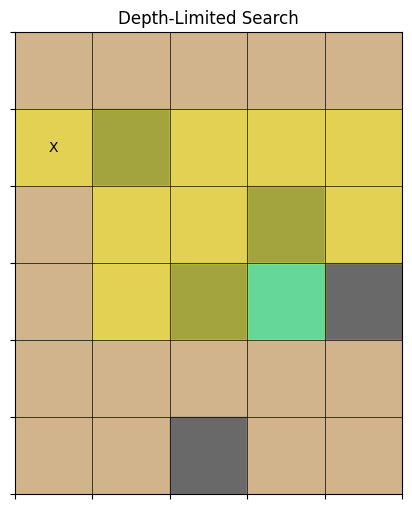

Iterative Deepening Search: шлях знайдено
Час: 0.00028300000000314185
[None, 'RIGHT', 'RIGHT', 'RIGHT', 'DOWN', 'DOWN']


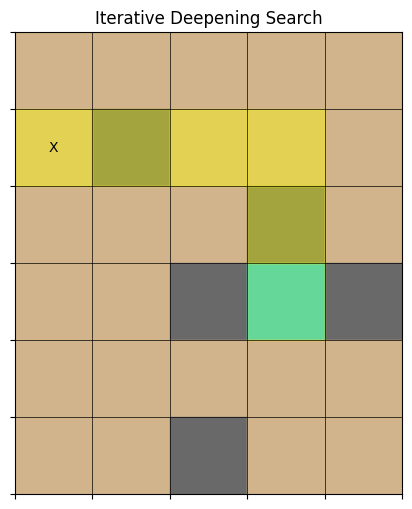

Greedy: шлях знайдено
Час: 0.00013799999999974943
[None, 'RIGHT', 'DOWN', 'DOWN', 'RIGHT', 'RIGHT']


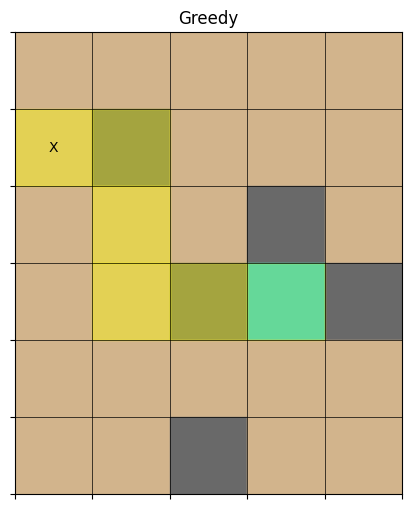

A*: шлях знайдено
Час: 0.0002099999999956026
[None, 'RIGHT', 'DOWN', 'DOWN', 'RIGHT', 'RIGHT']


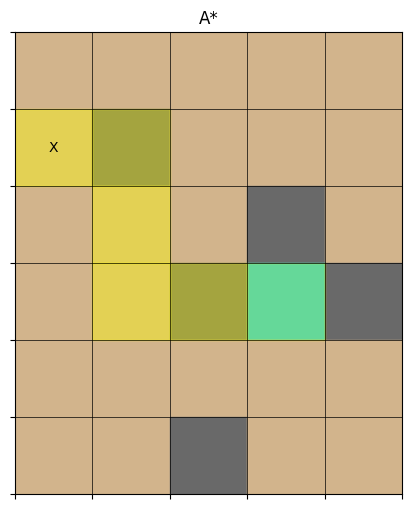

Iterative deepening A*: шлях знайдено
Час: 6.49999999993156e-05
[None, 'DOWN', 'DOWN', 'RIGHT', 'RIGHT', 'RIGHT']


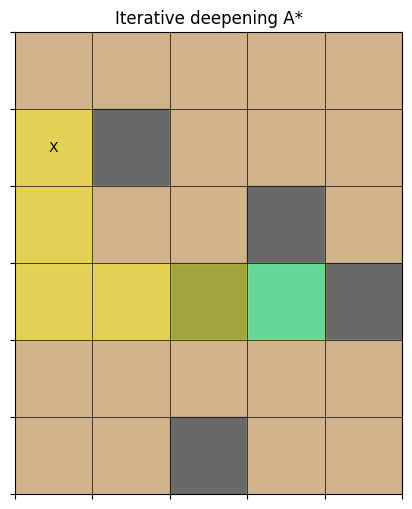

Jump Point Search: шлях знайдено
Час: 0.00020699999999607144
[None, 'RIGHT', 'DOWN', 'RIGHT', 'DOWN', 'RIGHT']


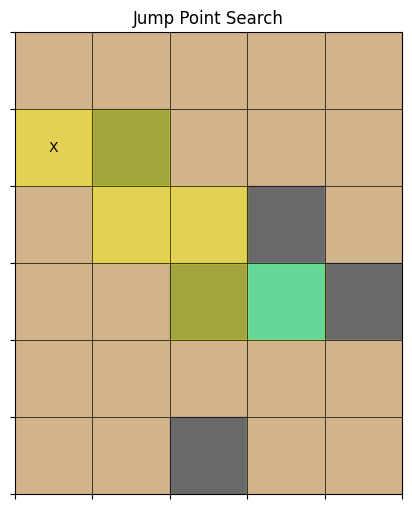

Breadth-first Search: шлях знайдено
Час: 0.011182999999995502
[None, 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'RIGHT']


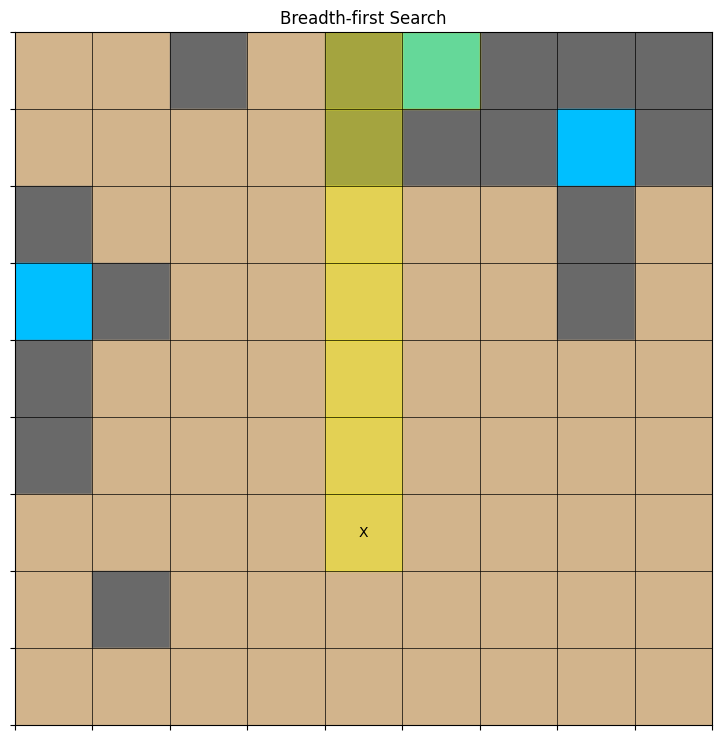

Depth-first search: шлях знайдено
Час: 0.000453999999997734
[None, 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'UP', 'RIGHT', 'RIGHT', 'RIGHT', 'UP', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'UP', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'UP']


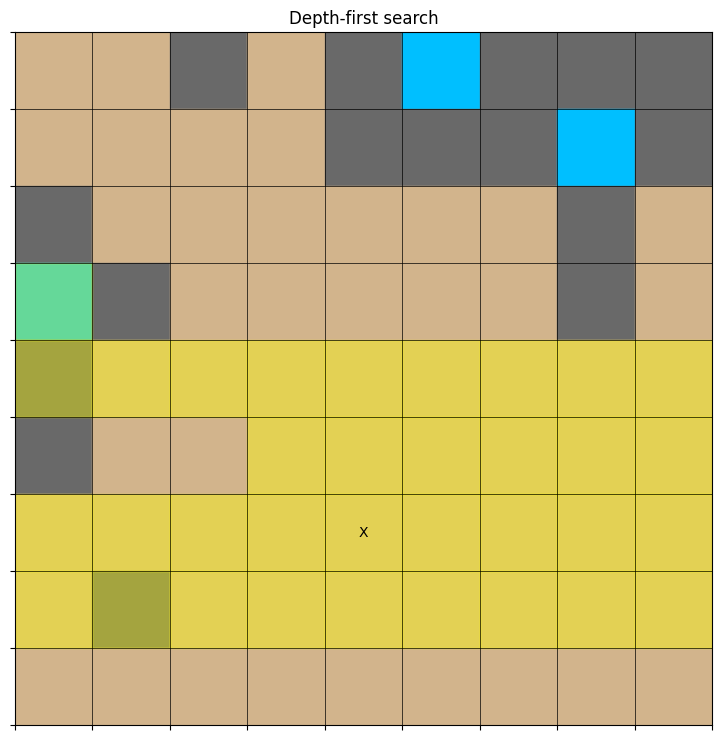

Depth-Limited Search: шлях знайдено
Час: 0.0005619999999950664
[None, 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'UP', 'LEFT', 'LEFT', 'UP', 'RIGHT', 'UP', 'UP', 'UP']


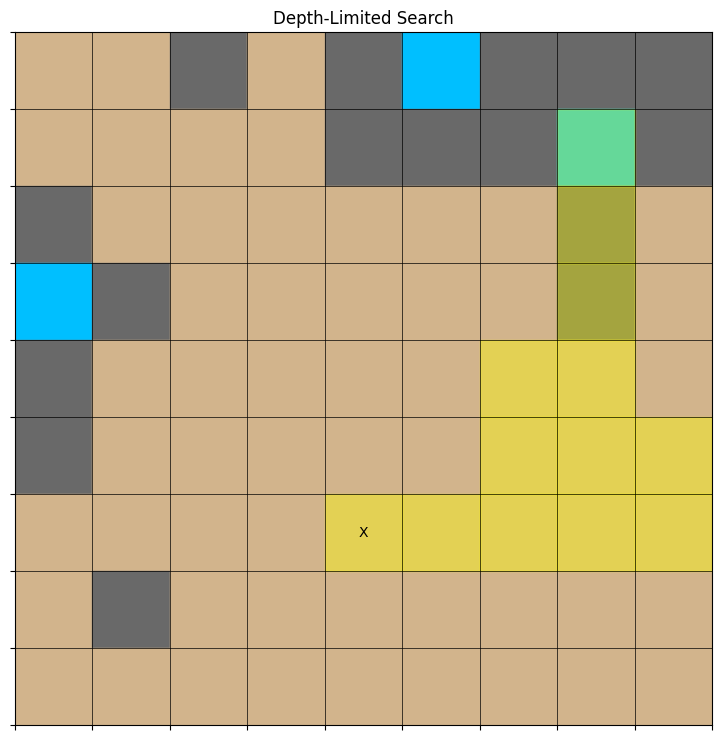

Iterative Deepening Search: шлях знайдено
Час: 0.00571599999999961
[None, 'RIGHT', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP']


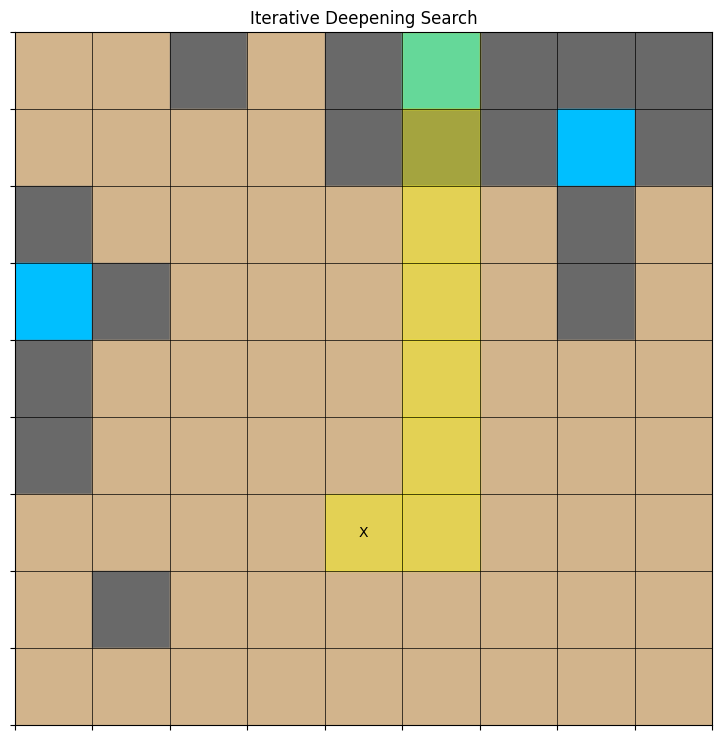

Greedy: шлях знайдено
Час: 0.00019100000000094042
[None, 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'RIGHT']


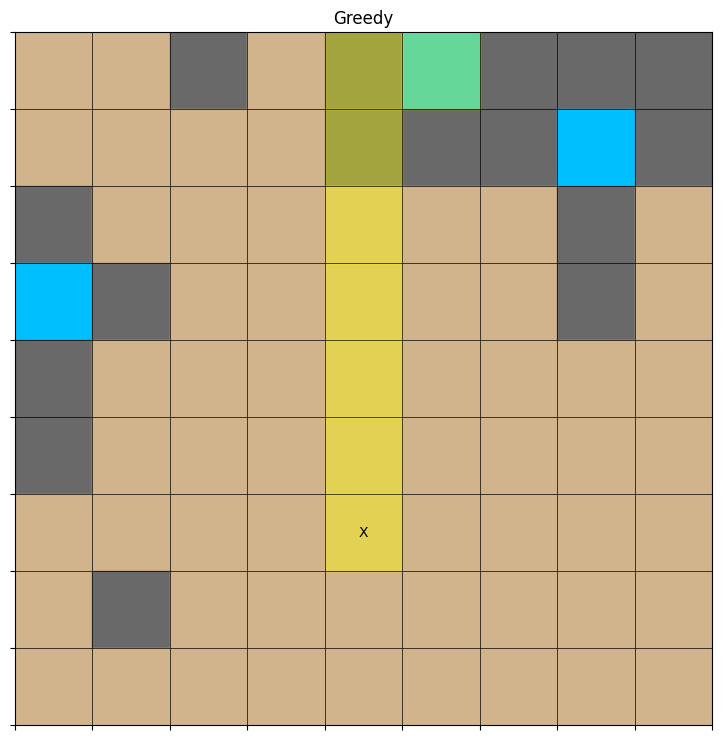

A*: шлях знайдено
Час: 0.0006040000000027135
[None, 'LEFT', 'LEFT', 'UP', 'UP', 'LEFT', 'UP', 'LEFT']


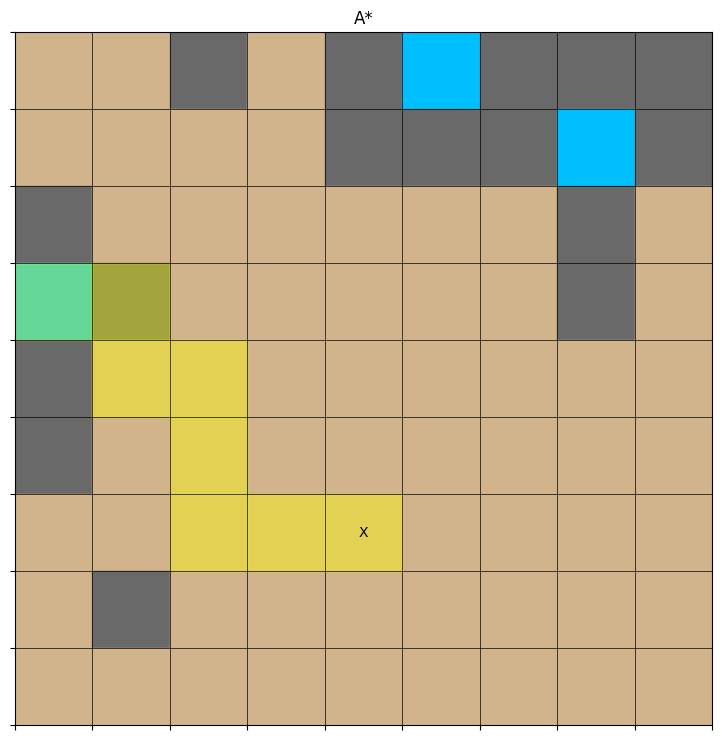

Iterative deepening A*: шлях знайдено
Час: 6.199999999978445e-05
[None, 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'RIGHT']


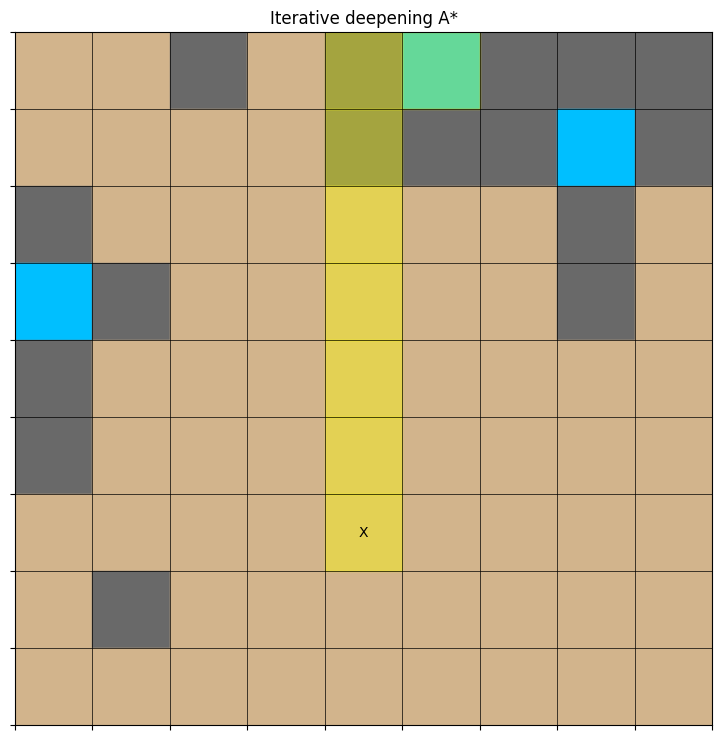

Jump Point Search: шлях знайдено
Час: 0.0014630000000011023
[None, 'LEFT', 'UP', 'LEFT', 'UP', 'LEFT', 'UP', 'LEFT']


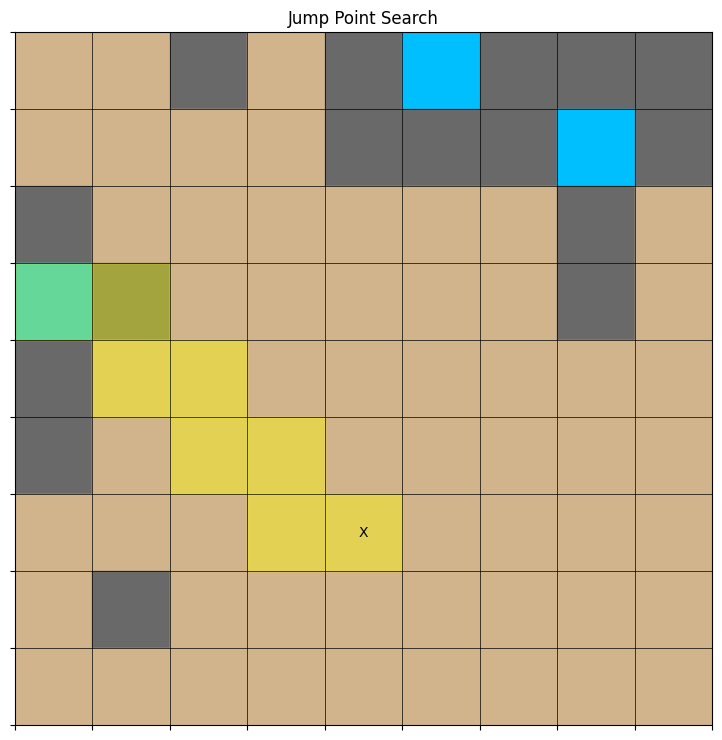

(0.011182999999995502,
 0.000453999999997734,
 0.0005619999999950664,
 0.00571599999999961,
 0.00019100000000094042,
 0.0006040000000027135,
 6.199999999978445e-05,
 0.0014630000000011023)

In [55]:

def test(algorithm, problem, name, visualize=True):
    st = time.process_time()
    if algorithm.__name__ == "limited_depth_first":
        result = algorithm(problem, depth_limit=12)
    else:
        result = algorithm(problem)
    end = time.process_time()

    exec_time = end - st
    if result:
        path = None
        try:
            path = [x for x, y in result.path()]
            cells = result.path()[-1][1][1]
        except Exception:
            try:
                path = [x for x, y in result]
                cells = result[-1][1][1]
            except Exception:
                cells = result
        
        if visualize: 
            print(f"{name}: шлях знайдено")
            print(f"Час: {exec_time}")
            print(path)
            visualize_map(problem.map, problem.initial[0], list(cells), name)
        return result, exec_time
    else:
        if visualize:
            print(f"{name}: НЕ знайдено", end='\n\n')
            print(f"Час: {exec_time}")
        return None, exec_time
    

def run_search(problem=None, length=9, width=9, num_lakes=1, returning_allowed=False, visualize=False):
    if problem == None:
        map, lake_goals, rock_goals = generate_map(length, width, num_lakes)
        problem = MapProblem(map=map, lake_goals=lake_goals, rock_goals=rock_goals, returning_allowed=returning_allowed)
    _, bf_t = test(breadth_first, problem, "Breadth-first Search", visualize)
    _, df_t = test(depth_first, problem, "Depth-first search", visualize)
    _, ldf_t = test(limited_depth_first, problem, "Depth-Limited Search", visualize)
    _, ids_t = test(iterative_limited_depth_first, problem, "Iterative Deepening Search", visualize)
    _, greedy_t = test(greedy, problem, "Greedy", visualize)
    _, astar_t = test(astar, problem, "A*", visualize)
    _, ida_star_t = test(ida_star, problem, "Iterative deepening A*", visualize)
    _, jps_t = test(jps.search, problem, "Jump Point Search", visualize)

    # bf_t = -1
    # df_t = -1
    # ldf_t = -1
    # ids_t = -1
    return bf_t, df_t, ldf_t, ids_t, greedy_t, astar_t, ida_star_t, jps_t

run_search(problem, visualize=True)
run_search(generated_problem, visualize=True)

# length = 100
# width = 100
# num_lakes = 1
# tests_num = 100

# times = [[], [], [], [], [], [], [], []]
# for _ in range(tests_num):
#     print("_",_)
#     bf_t, df_t, ldf_t, ids_t, greedy_t, astar_t, ida_star_t, jps_t = run_search(length=length, width=width, num_lakes=num_lakes, visualize=False)
#     times[0].append(bf_t)
#     times[1].append(df_t)
#     times[2].append(ldf_t)
#     times[3].append(ids_t)
#     times[4].append(greedy_t)
#     times[5].append(astar_t)
#     times[6].append(ida_star_t)
#     times[7].append(jps_t)
# times = np.array(times)

# print(f"Length: {length}")
# print(f"Width: {width}")
# print(f"num_lakes = {num_lakes}")
# print(f"tests_num = {tests_num}\n")

# print("TOTAL TIME")
# # print("BFS: ", np.sum(times[0]))
# # print("DFS: ", np.sum(times[1]))
# # print("DLS: ", np.sum(times[2]))
# # print("IDS: ", np.sum(times[3]))
# print("Greedy: ", np.sum(times[4]))
# print("A*: ", np.sum(times[5]))
# print("IDA: ", np.sum(times[6]))
# print("JPS: ", np.sum(times[7]))

# print("\nAVERAGE TIME")
# # print("BFS: ", np.average(times[0]))
# # print("DFS: ", np.average(times[1]))
# # print("DLS: ", np.average(times[2]))
# # print("IDS: ", np.average(times[3]))
# print("Greedy: ", np.average(times[4]))
# print("A*: ", np.average(times[5]))
# print("IDA: ", np.average(times[6]))
# print("JPS: ", np.average(times[7]))


### Висновки

Пошук у ширину (BFS). Цей алгоритм має хорошу повноту та здатний знаходити оптимальне рішення, проте вимагає багато пам'яті, оскільки зберігає всі вузли на поточному рівні перед переходом до наступного. Через це у великих лабіринтах BFS демонструє високий час виконання.

Пошук у глибину (DFS). У невеликих лабіринтах DFS показує кращу ефективність, адже потребує менше пам'яті. Проте у великих відкритих простора, таких як наша пустеля, цей метод може зайти в безвихідь, так і не знайшовши оптимального рішення. 

Обмежений пошук у глибину. Цей алгоритм є хорошим компромісом між BFS і DFS, встановлюючи максимальну глибину пошуку. Це запобігає зацикленню, але може призвести до пропуску рішень, якщо глибина розташування цілі перевищує обмеження.

Пошук у глибину з ітеративним заглибленням. Дає оптимальні результати і є найкращим по часовій і просторовій складності серед неінформованих алгоритмів.


Жадібний пошук. Для нашої задачі, де вартість переходів рівномірна, є одним з найкращих алгоримів, оскільки прямує одразу до найближчої цілі без лишніх обчислень.

A*. Завдяки використанню евристики A* має високу ефективність, але порівняно з іншими неінформованими алгоритмами, виявився досить повільним. 

Ітеративний A.* Цей алгоритм об'єднує переваги A* і алгориму пошуку в глибину з ітеративним заглибленням. На великих мапах ітеративний A* виявився дуже швидким і ефективним. Для нашої задачі це найкращий алгоримт.

JPS. Цей алгоритм призначений для оптимізації пошуку на картах з великою кількістю перешкод. У пустелі він теж працює добре, але виконує пошук досить повільно поврівняно з іншими інформованими алгоритмами.